In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [2]:
df = pd.read_csv('clean_turnstile_data.csv')

/Users/kendra/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
df['DATE'] = pd.to_datetime(df['DATE'])

In [4]:
df['TOTAL'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']

In [8]:
df['DAY_OF_WEEK'] = df['DATETIME'].dt.weekday

In [9]:
df.set_index('DATETIME', inplace=True)

In [10]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [11]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
DATETIME,,,,,,,,,,,,,,,,
2018-05-19 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,A002 R051 59 ST,24.0,2.0,26.0,5
2018-05-19 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,A002 R051 59 ST,20.0,24.0,44.0,5
2018-05-19 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,A002 R051 59 ST,81.0,77.0,158.0,5
2018-05-19 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,A002 R051 59 ST,196.0,66.0,262.0,5
2018-05-19 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,A002 R051 59 ST,227.0,39.0,266.0,5


In [12]:
uni_stn_list = df['STATION'].unique()
len(uni_stn_list)

374

In [ ]:
s = uni_stn_list[0]
df_s = df[df['STATION'] == s]
# df_s.groupby(['C/A','UNIT','SCP'])['LINENAME'].count()
len(df_s.groupby(['C/A','UNIT','SCP']).size()), len(df_s.groupby(['C/A','UNIT']).size())

In [ ]:
df_s.groupby(['C/A','UNIT']).size()

Resample dataframe every 4 hours:

In [13]:
df2 = df.groupby(['STATION']).resample(rule='4H').sum().reset_index()

In [17]:
# Day of Week gets summed because it's a number. Re-compute
df2['DAY_OF_WEEK'] = df2['DATETIME'].dt.weekday

In [14]:
df2.drop(['ENTRIES','EXITS'], axis=1, inplace=True)

In [54]:
d_vs_e = ['wkday']*5 + ['wkend']*2
wkday_wkend_dict = dict(zip(range(7), d_vs_e))
df2['WKDAY_WKEND'] = df2['DAY_OF_WEEK'].map(wkday_wkend_dict)

In [20]:
# it is no longer necessary to make a new dataframe, but I kept it in, because df3 is used below. Can clean up later
df3 = df2.copy()

df3['DATE'] = pd.to_datetime(df3['DATETIME'].dt.date)
df3['TIME'] = df3['DATETIME'].dt.time

,STATION,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK,DATE,TIME
0,1 AV,2018-05-19 00:00:00,1687.0,1107.0,2794.0,5,2018-05-19,00:00:00
1,1 AV,2018-05-19 04:00:00,673.0,1041.0,1714.0,5,2018-05-19,04:00:00
2,1 AV,2018-05-19 08:00:00,2864.0,3578.0,6442.0,5,2018-05-19,08:00:00
3,1 AV,2018-05-19 12:00:00,4839.0,5416.0,10255.0,5,2018-05-19,12:00:00
4,1 AV,2018-05-19 16:00:00,4982.0,6319.0,11301.0,5,2018-05-19,16:00:00


In [ ]:
df3.to_csv('resampled_turnstile_data.csv')

### Sum over all data

to get a list of high-volume stations

In [33]:
grp2 = df3.groupby(['STATION'])['ENTRY_DIFFS','EXIT_DIFFS', 'TOTAL'].sum().reset_index()

In [85]:
highest_vol = list(set(grp2.sort_values('TOTAL').tail(16)['STATION']))
lowest_vol = list(set(grp2.sort_values('TOTAL').head(16)['STATION']))
rand_vol = list(set(grp2.sort_values('TOTAL').sample(16)['STATION']))

n = len(grp2)

mid_vol = list(set(grp2.sort_values('TOTAL').iloc[(n//2)-7:(n//2)+7]['STATION']))

## ANALYZE DATA

### Volume by 4-hr time slice

What stations experience the top volume in a 4-hr period?

Play with # in head() to get desired # of stations

In [22]:
top_vol_4hr = list(set(df3.sort_values('TOTAL', ascending=False).head(400)['STATION']))

The same stations have highest volume within a 4-hour period and summed over a month:

In [36]:
top_vol_4hr.sort() == highest_vol.sort()

True

Histogram of 4-hr volumes? (Magnitude of # of people they can reach)

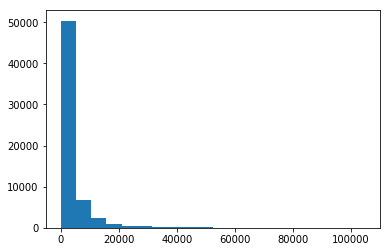

In [32]:
plt.hist(df3['TOTAL'], bins=20);

### Chaoticness of week vs weekend

Std Dev as a measure of 'chaoticness' of a station:

In [51]:
grp4 = df2.groupby(['STATION','WKDAY_WKEND'])['TOTAL'].std().unstack()
grp4['CHAOS_DIFF'] = grp4['wkday'] - grp4['wkend'] 

In [55]:
grp4.sort_values('CHAOS_DIFF').head()

WKDAY_WKEND,wkday,wkend,CHAOS_DIFF
STATION,,,
METS-WILLETS PT,2775.977453,3338.545823,-562.568370
PRINCE ST,3688.798199,4233.418236,-544.620037
QUEENSBORO PLZ,1953.665191,2395.627514,-441.962322
CONEY IS-STILLW,2824.771777,3170.284868,-345.513091
RIT-ROOSEVELT,296.358365,419.021775,-122.663410


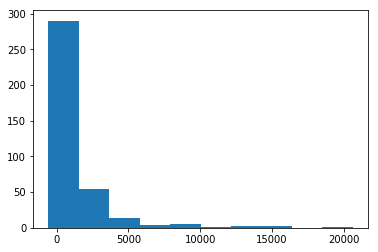

In [109]:
plt.hist(grp4['CHAOS_DIFF']);

Also compute asbsolute & % difference between weekend and weekday ridership:

In [58]:
grp5 = df2.groupby(['STATION','WKDAY_WKEND'])['TOTAL'].sum().unstack()
grp5['WKEND_DIFF'] = grp5['wkday'] - grp5['wkend']
grp5.sort_values('WKEND_DIFF').head()

WKDAY_WKEND,wkday,wkend,WKEND_DIFF
STATION,,,
ORCHARD BEACH,402.0,788.0,-386.0
ST. GEORGE,1143.0,0.0,1143.0
BROAD CHANNEL,6037.0,1111.0,4926.0
BEACH 105 ST,10478.0,2456.0,8022.0
BEACH 98 ST,16777.0,3827.0,12950.0


In [124]:
hb_data = grp5.sort_values('WKEND_DIFF').tail(15)['WKEND_DIFF'].values

<BarContainer object of 15 artists>

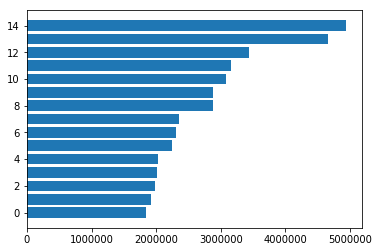

In [126]:
plt.barh(np.arange(len(hb_data)), hb_data)

Can merge these df's with previous one (df2) to compare these stations with TOTAL volume

In [127]:
grp4.head()

WKDAY_WKEND,wkday,wkend,CHAOS_DIFF
STATION,,,
1 AV,4200.039851,3197.111222,1002.928629
103 ST,5222.886262,2872.175267,2350.710995
103 ST-CORONA,2569.509990,1521.139438,1048.370552
104 ST,427.165616,156.746713,270.418904
110 ST,1844.339882,1148.413614,695.926268


In [128]:
df4 = pd.merge(df2, grp4, on='STATION')

In [130]:
df4 = pd.merge(df4, grp5, on='STATION')

In [132]:
df4.drop(['wkday_y','wkend_y'], axis=1, inplace=True)

df4.rename(columns={'wkday_x':'wkday_std', 'wkend_x':'wkend_std'}, inplace=True)

In [138]:
grp6 = pd.merge(grp2, grp4, on='STATION')
grp6 = pd.merge(grp6, grp5, on='STATION')

In [140]:
grp6.drop(['wkday_y','wkend_y'], axis=1, inplace=True)
grp6.rename(columns={'wkday_x':'wkday_std', 'wkend_x':'wkend_std'}, inplace=True)

In [141]:
grp6.head()

,STATION,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,wkday_std,wkend_std,CHAOS_DIFF,WKEND_DIFF
0,1 AV,571582.0,624905.0,1196487.0,4200.039851,3197.111222,1002.928629,641011.0
1,103 ST,804844.0,543799.0,1348643.0,5222.886262,2872.175267,2350.710995,870755.0
2,103 ST-CORONA,503029.0,365677.0,868706.0,2569.509990,1521.139438,1048.370552,493492.0
3,104 ST,71630.0,32287.0,103917.0,427.165616,156.746713,270.418904,70845.0
4,110 ST,278100.0,232013.0,510113.0,1844.339882,1148.413614,695.926268,308661.0


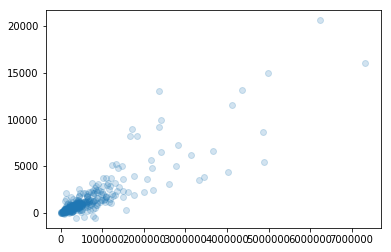

In [146]:
plt.scatter(grp6['TOTAL'],grp6['CHAOS_DIFF'], alpha=0.2)

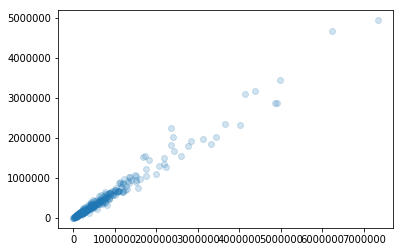

In [149]:
plt.scatter(grp6['TOTAL'],grp6['WKEND_DIFF'], alpha=0.2)

Compute chaos and weekend diff as % of total

### Sum by Date

To make sure there are no anomalies on a certain day

In [59]:
grp3 = df3.groupby(['STATION','DATE'])['ENTRY_DIFFS','EXIT_DIFFS','TOTAL'].sum().reset_index()

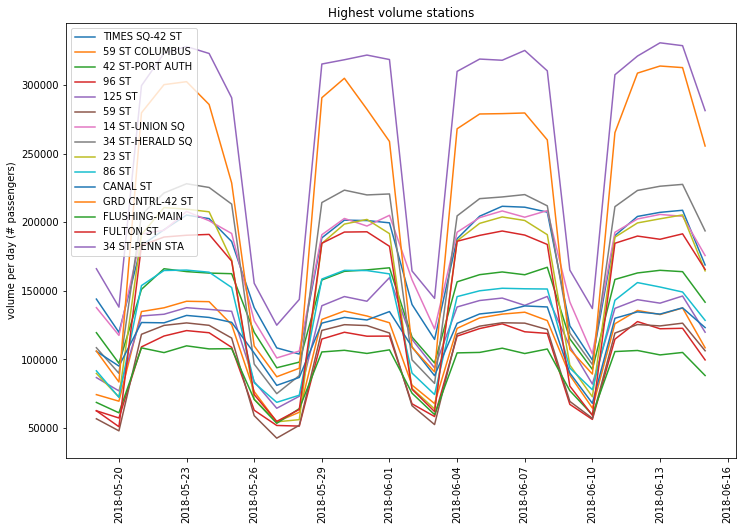

In [60]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Highest volume stations');

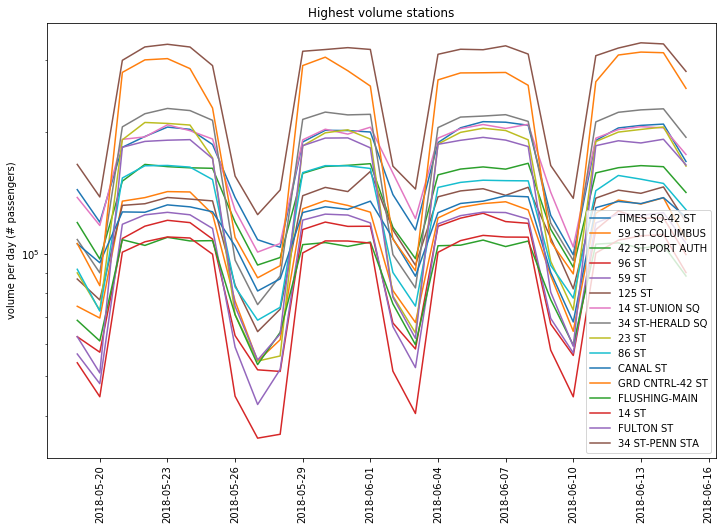

In [150]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.semilogy(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Highest volume stations');

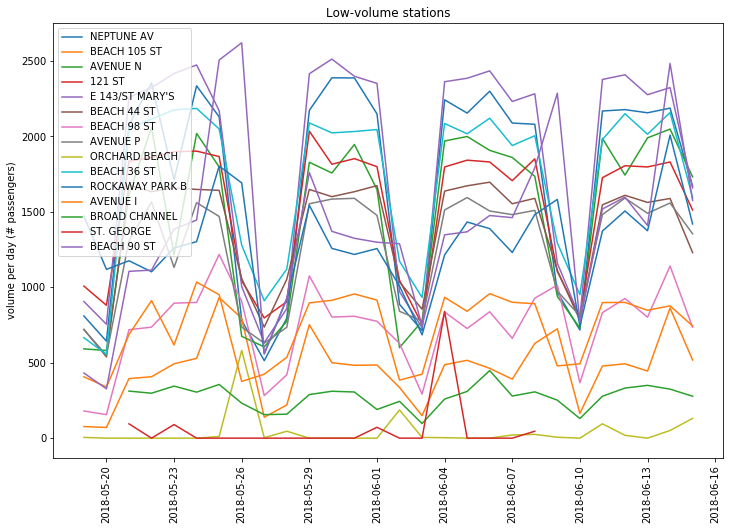

In [74]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in lowest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Low-volume stations');

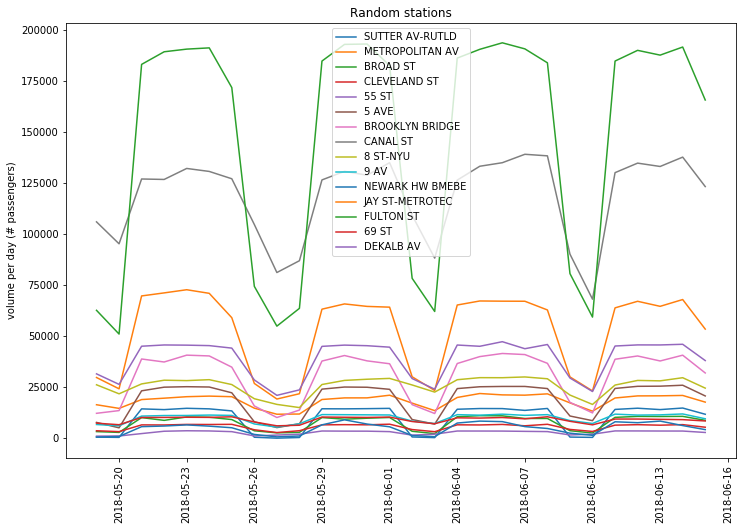

In [72]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in rand_vol:
    dum_df = grp3[grp3['cSTATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Random stations');

### Average by Day of week

In [75]:
grp1 = df3.groupby(['STATION', 'DAY_OF_WEEK'])['ENTRY_DIFFS','EXIT_DIFFS','TOTAL'].mean().reset_index()

In [76]:
xlabels_dow = calendar.day_name[:]

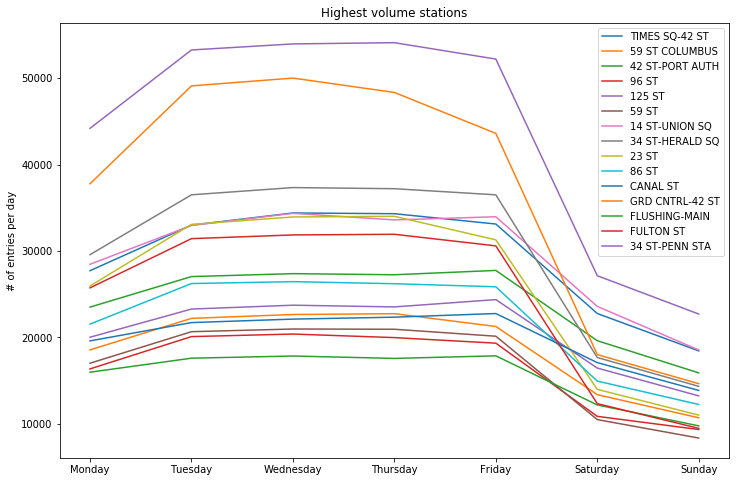

In [77]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['TOTAL'], label=s)

# xticklocs = ax.get_xticks()
plt.xticks(np.arange(7), xlabels_dow)
# plt.xticks(rotation=90)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Highest volume stations');

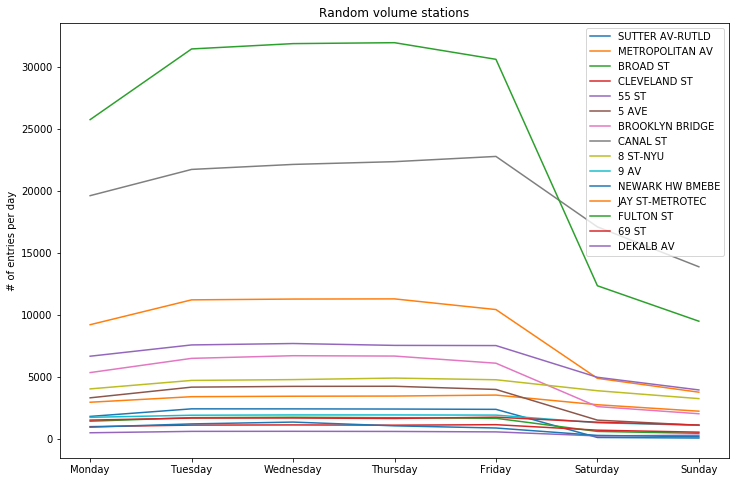

In [78]:
fig, ax = plt.subplots(figsize=[12,8])

for s in rand_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['TOTAL'], label=s)

# xticklocs = ax.get_xticks()
plt.xticks(np.arange(7), xlabels_dow)
# plt.xticks(rotation=90)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Random volume stations');

### Heatmap: volume of traffic by day of week & time of day, for a given station

In [89]:
vmax = df3['TOTAL'].max() * 1.5
vmin = df3['TOTAL'].min()

In [79]:
xlabel_hm = [str(int(x)) + 'h' for x in np.linspace(0,20,6)]
ylabel_hm = calendar.day_name[:]

In [80]:
def heatmap_data_by_day(s, data_col, year, month, day):
    '''Inputs:
        station key s 
        data_col (e.g. 'ENTRY_DIFFS')
        date: year, month, day
    Returns 
        Dataframe summed over that date, for that station, from that data_col'''
    d = dt.datetime(year, month, day)
    dum_df = df3[(df3['DATE'] == d) & (df3['STATION'] == s)]
    return dum_df.groupby('DATETIME')[data_col].sum()

In [81]:
def heatmap_data_by_dow(s, data_col, dow):
    '''Inputs:
        station key s 
        data_col (e.g. 'ENTRY_DIFFS')
        dow (day of weeks, an integer from 0-6, with 0 being Monday)
    Returns: 
        Dataframe summed over that day of week, grouped by time, for that station, from that data_col'''
    dum_df = df3[(df3['DAY_OF_WEEK'] == dow) & (df3['STATION'] == s)]
    return dum_df.groupby('TIME')[data_col].sum()

Use total. Make a heatmap for each station in highest_vol list.

In [84]:
len(highest_vol)

15

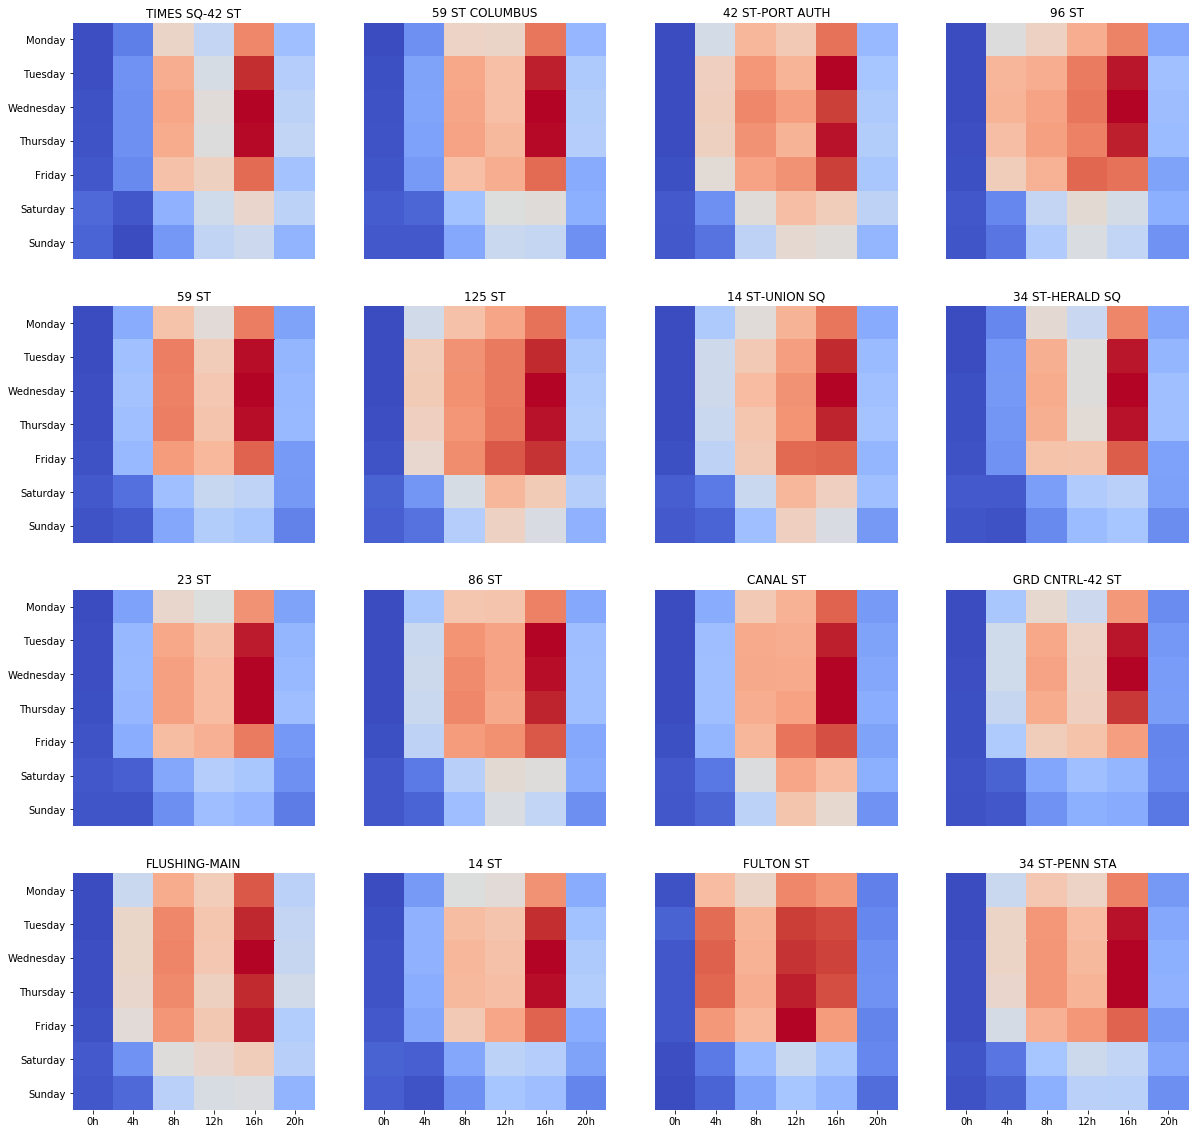

In [86]:
fig, ax = plt.subplots(4,4, figsize=(20,20))

for i, s in enumerate(highest_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=ylabel_hm
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xlabel_hm
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, 
                cbar=False, cmap='coolwarm')
#     sns.heatmap(hm_data, cbar=False)
    plt.title(s)
    



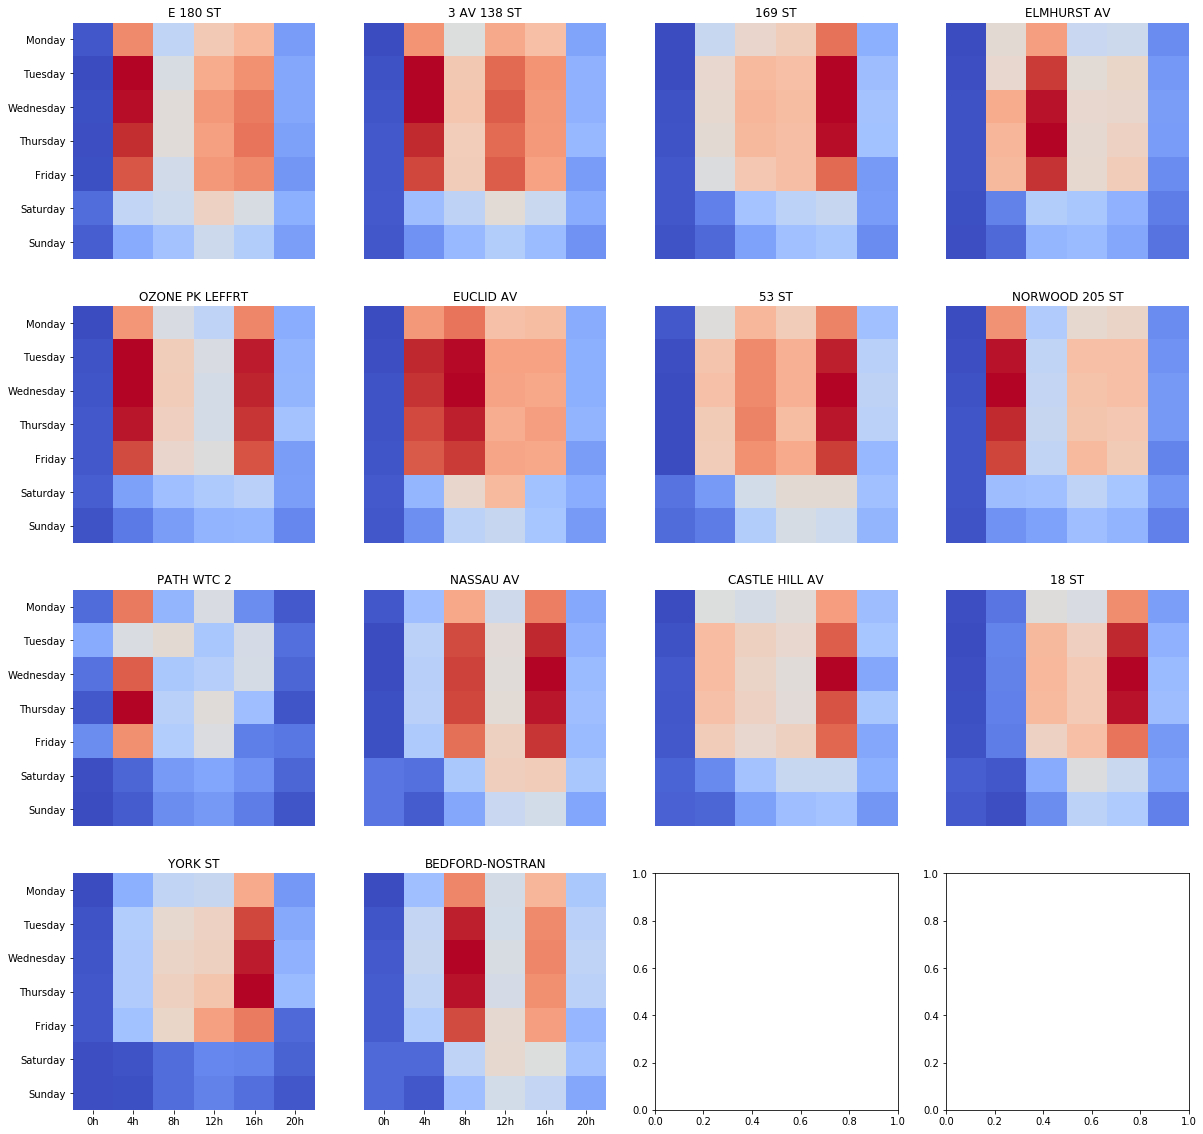

In [107]:
fig, ax = plt.subplots(4,4, figsize=(20,20))

for i, s in enumerate(mid_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=ylabel_hm
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xlabel_hm
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, 
                cbar=False, cmap='coolwarm')
    # don't use vmax / vmin here, otherwise most stations' plots are just blue
    
    plt.title(s)
    

Text(0.5,1,'Low volume')

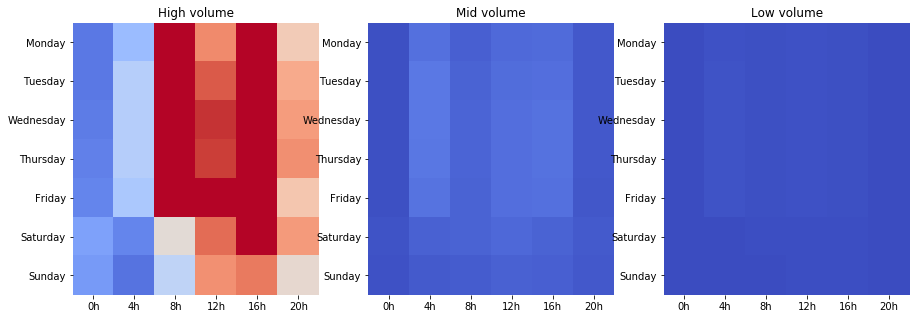

In [106]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

plt.subplot(1,3,1)
hm_data1 = [heatmap_data_by_dow(highest_vol[0], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data1, xticklabels = xlabel_hm, yticklabels=ylabel_hm, 
            cbar=False, vmax=vmax, vmin=0, cmap='coolwarm') 
hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
plt.title('High volume')

plt.subplot(1,3,2)
hm_data2 = [heatmap_data_by_dow(mid_vol[0], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data2, xticklabels = xlabel_hm, yticklabels=ylabel_hm, 
            cbar=False, vmax=vmax, vmin=0, cmap='coolwarm')
hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
plt.title('Mid volume')

plt.subplot(1,3,3)
hm_data3 = [heatmap_data_by_dow(lowest_vol[0], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data3, xticklabels = xlabel_hm, yticklabels=ylabel_hm, 
            cbar=False, vmax=vmax, vmin=0, cmap='coolwarm')
hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
plt.title('Low volume')


    